<a href="https://colab.research.google.com/github/Aazat/Python-for-research/blob/main/Queue_Admission_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [31]:
import random
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2

## Sample Next arrival

In [2]:

# A state is (n1,n2, t1,t2)
# action ['00', '10','01']
C = 5
L1= 0.02
L2 = 0.0166
T_p = 6
T_np = 10
W1 = 2
W2 = 1

ACTIONS = ['00','10','01']
time_constants = {'00': 0, '10': T_p, '01': T_np}


def sample_next_arrival(arrival_rate ):
    """
    returns the arrival time for next state arrivals, following an exponential distribution.
    """
    return int(random.expovariate(arrival_rate))


def sample_next_state(state , action):
    """Takes an numpy array of shape (4,) (n1,n2,t1,t2 as states), and the action to perform and samples the next state and reward as per the transition rules"""
    # sample action, equally likely.
    n1,n2,t1,t2 = state.flatten()

    # arrival time remaining for next states...only initialized here globally
    n1_,n2_,t1_ ,t2_ = n1,n2,t1,t2


    T = time_constants[action]

    if action == '00':
        if n1 + n2 == C:
            t1_,t2_ = sample_next_arrival(L1), sample_next_arrival(L2)
            reward = -1e6
            return np.array((n1_,n2_,t1_,t2_),ndmin=2),reward

        if t1 < t2:
            # Here we can use uniform approach as well, for now we will just pick priority customer as our policy.
            n1_ += 1
            reward = -(W1*n1 + W2*n2)*(t1)
            t1_ = sample_next_arrival(L1)
            t2_ = t2-t1
        elif t1 == t2:
            c = np.random.randint(0,2)
            n1_ += (c == 0)
            n2_ += (c == 1)
            reward = -(W1*n1 + W2*n2)*(t1) if c==0 else -(W1*n1 + W2*n2)*(t2)
            t1_ = sample_next_arrival(L1) if c == 0 else t1 - t2
            t2_ = sample_next_arrival(L2) if c == 1 else t2 - t1

        else:
            n2_ += 1
            reward = -(W1*n1 + W2*n2)*(t2)
            t2_ = sample_next_arrival(L2)
            t1_ = t1 - t2

        return np.array((n1_,n2_,t1_,t2_),ndmin=2),reward

    else:
        if (n1 < 1 and action == '10') or (n2 < 1 and action == '01'):
            return np.array((n1_, n2_, t1_, t2_),ndmin=2), -1e6

        # T is now serving time, now we have various cases...
        if T < min(t1,t2):

            t1_ -= T
            t2_ -= T
            reward = -(W1*(n1_) + W2*n2_) *T
            return np.array((n1_,n2_,t1_,t2_),ndmin=2),reward

        reward_list = [-((n1 - (action == '10'))*W1 + (n2 - (action == '01'))*W2)*T]
        while( (T >= t1_ or T >= t2_) and n1_ + n2_ < C ):
            if t1_ < t2_:
                T -= t1_
                t2_ -= t1_
                n1_ += 1
                reward_list.append(-(W1*T))
                t1_ = sample_next_arrival(L1)
            elif t2_ < t1_:
                T -= t2_
                t1_ -= t2_
                n2_ += 1
                reward_list.append(-(W2*T))
                t2_ = sample_next_arrival(L2)
            elif t1_ == t2_ and (n1_ + n2_ +1 < C ):
                T -= t1_
                n1_ += 1
                n2_ += 1
                reward_list.append(-(W1 + W2)*T)
                t1_ = sample_next_arrival(L1)
                t2_ = sample_next_arrival(L2)
            elif t1_ == t2_:
                # PICK WHICH ONE TO KEEP
                c = np.random.randint(0,2)
                n1_ += (c == 0)
                n2_ += (c == 1)
                r = -(W1*T) if c == 0 else -(W2*T)
                reward_list.append(r)

                t1_ = sample_next_arrival(L1)
                t2_ = sample_next_arrival(L2)

        t1_ = t1_ - T
        if t1_ < 0:
            t1_ = sample_next_arrival(L1)

        t2_ -= T
        if t2_ < 0:
            t2_ = sample_next_arrival(L2)

        # We have to make the reward as bellman optimal update, that is max of all actions.???
        # reward = -((W1 * (n1_ - n1-1))*(T/2) + W2*(n2_ - n2)*(T/2)) - (W1 * (n1 - 1) + W2 * (n2))*(T)
        reward = sum(reward_list)
        n1_ -= (action == "10")
        n2_ -= (action == "01")
        return np.array((n1_,n2_,t1_,t2_),ndmin=2), reward

    # pass


#### generate trajectory

In [3]:
def get_optimal_action(state,V, k=10, discount = 0.03):
  """
  Calculates the optimal action for the function approximator V, at the given state
  """
  # Perform all actions
  yi = np.full(len(ACTIONS), -np.inf)
  for i,action in enumerate(ACTIONS):
    # sample k states to approximate E[V] for the given action
    sj,R = zip(*[sample_next_state(state,action) for _ in range(k)])
    V_pred = V.predict(np.array(sj),verbose=0).squeeze()

    q_a = np.mean(R + discount*V_pred)
    yi[i] = q_a

  return ACTIONS[np.argmax(yi)]

In [4]:
# Example run

def generate_trajectory(policy , is_approximator=False,initial_state = (0,0,5,3), discount = 0.03, steps = 100 ):

    # discounted_trajectory_reward
    V_pi = 0
    # backup = []
    if is_approximator:
      for _ in range(steps):
        action = get_optimal_action(initial_state, policy)
        next_state ,reward = sample_next_state(initial_state, action)
        V_pi  += reward * (discount ** _)
        initial_state = next_state

        # backup.append((next_state,reward))
    else:
      for _ in range(steps):
          action = policy(initial_state)
          next_state ,reward = sample_next_state(initial_state, action)

          V_pi  += reward * (discount ** _)
          initial_state = next_state

          # backup.append((next_state,reward))
    return V_pi

#### uniform action policy

In [5]:
# Uniform action policy
def uniform_action_policy(state = None):
    return random.choice(ACTIONS)

V_u = generate_trajectory(uniform_action_policy, steps=1000)
print(V_u)

-1030000.0004547548


#### custom policy

In [6]:
# Testing a different policy

def custom_policy(state):
    n1,n2,t1,t2 = state
    if n1 + n2 == 0:
        return '00'
    if n1 > n2:
        return '10'
    return '01'

V_p = generate_trajectory(policy=custom_policy, steps= 1000)
print(V_p)

-0.49113402061068107


#### get linear function approximator

In [7]:
### FITTED VALUE ITERATION
# model is our value function approximator
def get_linear_function_approximator(w_i=1):

    inputs = tf.keras.Input(shape=(4,))
    outputs = tf.keras.layers.Dense(1, kernel_initializer=tf.zeros_initializer())(inputs) if w_i == 0 else tf.keras.layers.Dense(1)(inputs)
    V = tf.keras.Model(inputs=inputs, outputs=outputs)
    V.compile(optimizer='adam', loss='mean_squared_error')

    return V

#### sample random state

In [22]:
def sample_random_state(n=1,t1_upper_bound = 100, t2_upper_bound=100):
    return np.random.randint([0,0,0,0], [C+1,C+1,t1_upper_bound, t2_upper_bound], (n,4))

In [9]:
V = get_linear_function_approximator(w_i=0)

state = sample_random_state()
V_state_ = V.predict([state], verbose=0)

print(V_state_)

[[0.]]


In [10]:
def plot_collected_losses(history, val=True):
    loss_collected = []
    val_loss_collected = []
    for hist in history:
        loss_collected.extend(hist.history['loss'])
        if val:
          val_loss_collected.extend(hist.history['val_loss'])
    if val:
      plt.plot(loss_collected, label='loss')
    plt.plot(val_loss_collected, label='val_loss')
    # plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

# Plot Loss

In [11]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

# Fitted Value Iteration

In [12]:
# Fitted Value Iteration
def fitted_value_iteration(V,iterations = 10,n = 50, k = 10, discount = 0.03, **kwargs):
    """
        n : number of initial random states,
        k : number of states to sample for each state
        V : Function approximator to train, 4d -> 1 mapping approximator.

    """

    n_random_states= sample_random_state(n=n)
    history = []
    for _ in range(iterations):
        X , y= [], []
        for state in n_random_states:

            yi = np.full(3, -np.inf)
            for i,action in enumerate(ACTIONS):
                sj, R = zip(*[sample_next_state(state,action) for _ in range(k)])

                V_pred = V.predict(np.array(sj),verbose=0).squeeze()

                q_a = np.mean(R + discount*V_pred)
                yi[i] = q_a

            X.append(state)
            y.append(np.max(yi))

        X = np.array(X)
        y = np.array(y)

        hist = V.fit(X,y, **kwargs)
        history.append(hist)
    return history


## Fitted Value iteration with gradient update approach (instead of model.fit)

In [13]:
# Fitted Value Iteration

def fitted_value_iteration_updated(V,iterations = 10,n = 50, k = 10, discount = 0.03,epsilon=1e-6, batch_size=5, epochs = 10,optimizer=None,loss_function=None):
    """
        n : number of initial random states,
        k : number of states to sample for each state
        V : Function approximator to train, 4d -> 1 mapping approximator.

    """
    optimizer = tf.keras.optimizers.Adam()
    loss_function = tf.keras.losses.MeanSquaredError()

    n_random_states= [sample_random_state() for _ in range(n)]
    history = []
    for _ in range(iterations):
        X , y= [], []
        for state in n_random_states:

            yi = np.full(3, -np.inf)
            for i,action in enumerate(ACTIONS):
                sj, R = zip(*[sample_next_state(state,action) for _ in range(k)])

                V_pred = V.predict(np.array(sj),verbose=0).squeeze()

                q_a = np.mean(R + discount*V_pred)
                yi[i] = q_a

            if abs(np.max(yi)) > 1000:
              print("max  exploded: ", state)
              return
            X.append(state)
            y.append(np.max(yi))

        X = tf.data.Dataset.from_tensor_slices(X)
        y = tf.data.Dataset.from_tensor_slices(y)

        dataset = tf.data.Dataset.zip((X,y)).batch(batch_size=batch_size)
        for _ in range(epochs):
          # losses = np.full(n//batch_size,0, dtype=np.float32)
          epoch_loss = 0
          i = 0
          for X_batch, y_batch in dataset:
            with tf.GradientTape() as tape:
              V_pred = V(X_batch)
              # loss = tf.reduce_mean(tf.square(V_pred - y))
              loss = loss_function(V_pred, y_batch)
              epoch_loss += loss
              i += 1
              # print("Prediction: ", V_pred.numpy().squeeze())
              print("-", end="")
              # if loss.numpy() > 1000:
              #   print("Y : ",y_batch, "\n Prediction: ",V_pred)
              #   return
              gradients = tape.gradient(loss, V.trainable_variables)
              # print("gradients",gradients)
            optimizer.apply_gradients(zip(gradients, V.trainable_variables))
            # print("WEGHTS: ", [weight.numpy().squeeze() for weight in V.weights])
          history.append(epoch_loss)
          print(f": loss {epoch_loss}")
        print()

        if loss < epsilon:
          break
    return history


## Training linear model

In [ ]:
V = get_linear_function_approximator(w_i=0)

history1 = fitted_value_iteration(V,iterations=10, n=1000, batch_size = 25, discount= 0.0001)

40/40 [==============================] - 0s 2ms/step - loss: 881.6593


In [ ]:
plot_collected_losses(history1, val=False)

In [ ]:
history1[0]

In [ ]:
inputs = tf.keras.Input(shape=(4,))
# outputs = tf.keras.layers.Dense(1)(inputs)
outputs = tf.keras.layers.Dense(1, kernel_initializer=tf.zeros_initializer())(inputs)
V = tf.keras.Model(inputs=inputs, outputs=outputs)
# V.summary()

In [ ]:
history2 = fitted_value_iteration_updated(V,iterations=5, n=10, batch_size=2, discount = 0.001)

In [ ]:
history[0]

array([3978.    , 1793.2145, 2322.3315, 3071.0264, 4702.1147],
      dtype=float32)

In [ ]:
history = np.array(history)

In [ ]:
history.shape

(50, 5)

In [ ]:
def plot_loss_updated(history, flat=True):
  if flat:
    flat_data = np.array(history).flatten()
    plt.plot(flat_data)
  else:
    means = np.mean(history,axis=1)
    plt.plot(means)

In [ ]:
plot_loss(history)

In [ ]:
plot_loss(history, flat=False)

In [ ]:
len(history)

50

In [ ]:
state = (0,0,5,3)
V_pis = np.mean([generate_trajectory(policy=custom_policy, steps=1000, initial_state=state) for _ in range(10)])
print(V_pis)
print(V.predict([state]))

-0.5012809427952158
1/1 [==============================] - 0s 45ms/step
[[-1.7724028]]


In [ ]:
state = (0,0,5,3)   # it is clear that the optimal action here is '00'
Q_V_pred = get_optimal_action(state = state, V=V)
print(Q_V_pred)

00


In [ ]:
state = (3,2,5,3)   # it is clear that the optimal action here is '00'
Q_V_pred = get_optimal_action(state = state, V=V)
print(Q_V_pred)

10


In [ ]:
next_state,reward=sample_next_state(state,"10")

In [ ]:
next_state,reward

((2, 2, 41, 19), -36)

In [ ]:
next_state,reward=sample_next_state(state,"01")
next_state,reward

((3, 1, 153, 69), -70)

In [ ]:
V(np.expand_dims(np.array(state),axis=0))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-2.8292909]], dtype=float32)>

In [ ]:
V_s = generate_trajectory(V,is_approximator=True, steps=1)

In [ ]:
V_s

0.0

### testing trajectories

In [ ]:
# Compare custom policy and V approximator in trajectories
initial_state = (3,2,5,3)

V_uniform_action_policy = np.mean([ generate_trajectory(policy=uniform_action_policy, initial_state=initial_state)for _ in range(50)])
V_custom_policy = np.mean([ generate_trajectory(policy=custom_policy, initial_state=initial_state)for _ in range(50)])

V_approximator = np.mean([ generate_trajectory(policy=V, initial_state=initial_state, is_approximator=True) for _ in range(10)])

print("V uniform action policy: ", V_uniform_action_policy)
print("V custom policy: ", V_custom_policy)
print("V_ approximator: " , V_approximator)

V uniform action policy:  -344409.7306835926
V custom policy:  -37.84720650539768
V_ approximator:  -36.963331138257075


In [ ]:
import concurrent.futures

def generate_trajectory_parallel(policy, is_approximator=False, initial_state=(0,0,5,3), discount=0.03, steps=100, num_trajectories=10, num_threads=None):
    def generate_trajectory(step):
        state = initial_state
        V_pi = 0
        for _ in range(step):
            if is_approximator:
                action = get_optimal_action(state, policy)
            else:
                action = policy(state)
            next_state, reward = sample_next_state(state, action)
            V_pi += reward * (discount ** _)
            state = next_state
        return V_pi

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Generate multiple trajectories concurrently
        futures = [executor.submit(generate_trajectory, steps) for _ in range(num_trajectories)]

        # Retrieve results from the futures
        results = [future.result() for future in concurrent.futures.as_completed(futures)]

    return results


In [ ]:
import time

start = time.time()
V_approximator = np.mean([ generate_trajectory(policy=V, initial_state=initial_state, is_approximator=True) for _ in range(10)])
end = time.time()

print(f"time taken for 10 trajectories: {end-start}")

time taken for 10 trajectories: 273.78636479377747


In [ ]:
start = time.time()
results = generate_trajectory_parallel(policy=V, initial_state=initial_state, is_approximator=True)
end = time.time()
print(f"time taken for 10 trajectories in parallel : {end-start} seconds.")

time taken for 10 trajectories in parallel : 242.3895583152771 seconds.


In [ ]:
from joblib import Parallel, delayed
Parallel(n_jobs=2)(delayed(generate_trajectory)(V,True,initial_state) for _ in range(10))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.Zeros'>, which may lead to improper serialization.
  warnings.warn(


[-37.11340177209193,
 -36.044536082474224,
 -37.113377912164694,
 -37.11339396185567,
 -37.113402061855425,
 -37.112597072164945,
 -37.11340204449494,
 -37.113377735611664,
 -37.113402061855666,
 -37.11340206185508]

In [ ]:
start = time.time()
result = Parallel(n_jobs=2)(delayed(generate_trajectory)(V,True,initial_state) for _ in range(10))
end = time.time()

print(f"time with 2 jobs: {round(end-start,2)}")

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.Zeros'>, which may lead to improper serialization.
  warnings.warn(


time with 2 jobs: 187.56


In [ ]:
start = time.time()
result = Parallel(n_jobs=4)(delayed(generate_trajectory)(V,True,initial_state) for _ in range(10))
end = time.time()

print(f"time with 2 jobs: {round(end-start,2)}")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


time with 2 jobs: 195.55


## Non linear model

In [ ]:
# V_non_linear = tf.keras.Sequential([
#     # normalizer,
#     tf.keras.layers.Dense(units=1, input_shape=(4,)),
#     tf.keras.layers.Dense(units=64, activation='relu'),
#     tf.keras.layers.Dense(units=32, activation='relu'),
#     tf.keras.layers.Dense(units=16, activation='relu'),
#     tf.keras.layers.Dense(units=1),
# ])

V_non_linear = tf.keras.Sequential([
    Dense(64, activation='relu', input_shape=(4,), kernel_regularizer=l2(0.001)),  # L2 regularization
    Dropout(0.3),  # Dropout regularization
    Dense(32, activation='relu', kernel_regularizer=l1(0.001)),  # L1 regularization
    Dropout(0.2),
    Dense(1)
])
V_non_linear.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model

In [ ]:
history = fitted_value_iteration(V_non_linear, iterations=5,n=1000,epochs=10, callbacks=[early_stopping], batch_size=25,validation_split=0.2)

Epoch 1/10
32/32 [==============================] - 0s 7ms/step - loss: 150.1653 - val_loss: 42.4539
Epoch 2/10
32/32 [==============================] - 0s 6ms/step - loss: 144.0616 - val_loss: 37.7791
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 138.4942 - val_loss: 39.0560
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 127.0576 - val_loss: 43.0380
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 124.8292 - val_loss: 36.3687
Epoch 6/10
32/32 [==============================] - 0s 5ms/step - loss: 129.2650 - val_loss: 35.6618
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 135.6312 - val_loss: 38.2503
Epoch 8/10
32/32 [==============================] - 0s 5ms/step - loss: 117.7752 - val_loss: 37.8673
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 120.5067 - val_loss: 36.8213
Epoch 10/10
32/32 [==============================] - 0s 4ms/step - loss: 114.0341 - val_los

In [ ]:
import matplotlib.pyplot as plt

def plot_training_and_validation_losses(history_list):
    """
    Plot training and validation losses from a list of history objects returned from model.fit in TensorFlow.

    Args:
    - history_list: A list of history objects returned from model.fit in TensorFlow.

    Returns:
    - None
    """

    # Initialize lists to store cumulative training and validation losses
    cumulative_train_losses = []
    cumulative_val_losses = []

    # Iterate through each history object
    for history in history_list:
        # Extract the loss values for each epoch
        epoch_losses = history.history['loss']
        epoch_val_losses = history.history['val_loss']

        # Append the cumulative training and validation losses
        if not cumulative_train_losses:
            cumulative_train_losses = epoch_losses
            cumulative_val_losses = epoch_val_losses
        else:
            # Accumulate losses from previous epochs
            for i in range(len(epoch_losses)):
                cumulative_train_losses[i] += epoch_losses[i]
                cumulative_val_losses[i] += epoch_val_losses[i]

    # Plot the losses
    plt.plot(range(1, len(cumulative_train_losses) + 1), cumulative_train_losses, label='Training Loss')
    plt.plot(range(1, len(cumulative_val_losses) + 1), cumulative_val_losses, label='Validation Loss')
    plt.title('Cumulative Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Example usage:
# Assuming you have a list of history objects returned from model.fit
# history_list = [history_1, history_2, ...]
# plot_training_and_validation_losses(history_list)


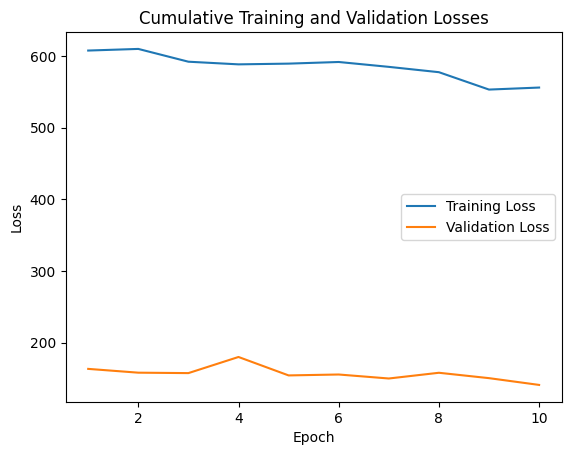

In [ ]:
plot_training_and_validation_losses(history)

In [ ]:
history_2 = fitted_value_iteration_updated(V_non_linear, iterations=5,n=500,epochs=10,batch_size=25)

loss tf.Tensor(27.661445754512325, shape=(), dtype=float64)


loss tf.Tensor(6.405321917959253, shape=(), dtype=float64)
loss tf.Tensor(9.470028712730016, shape=(), dtype=float64)
loss tf.Tensor(19.14685607622263, shape=(), dtype=float64)
loss tf.Tensor(22.27497893949084, shape=(), dtype=float64)
loss tf.Tensor(31.31937331110989, shape=(), dtype=float64)
loss tf.Tensor(55.795941771935915, shape=(), dtype=float64)
loss tf.Tensor(31.815595132732806, shape=(), dtype=float64)
loss tf.Tensor(43.79552422120823, shape=(), dtype=float64)
loss tf.Tensor(61.66734462420045, shape=(), dtype=float64)
loss tf.Tensor(19.455007136852032, shape=(), dtype=float64)
loss tf.Tensor(15.369281831276542, shape=(), dtype=float64)
loss tf.Tensor(54.09985501032235, shape=(), dtype=float64)
loss tf.Tensor(5.547085508806439, shape=(), dtype=float64)
loss tf.Tensor(27.17008281074982, shape=(), dtype=float64)
loss tf.Tensor(5.357081828706389, shape=(), dtype=float64)
loss tf.Tensor(20.358825090973873, shape=(), dtype=float64)
loss tf.Tensor(21.522368253614797, shape=(), dtype=

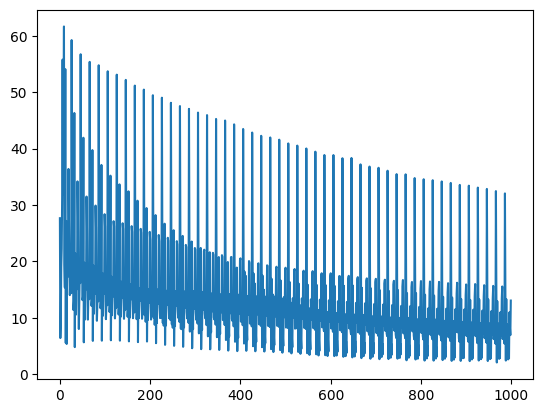

In [ ]:
plot_loss_updated(history_2)

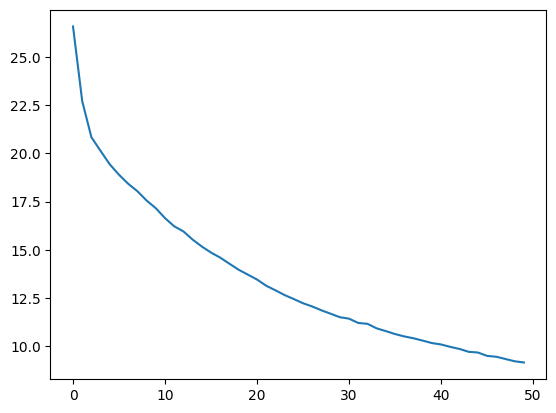

In [ ]:
plot_loss_updated(flat=False,history=history_2)

### testing trajectories with multi processing

In [ ]:
from concurrent.futures import ThreadPoolExecutor

In [ ]:
def execute_job(job):
    return job()

In [ ]:

def job_uniform_policy():
    return np.mean([generate_trajectory(policy=uniform_action_policy, initial_state=initial_state) for _ in range(10)])

def job_custom_policy():
    return np.mean([generate_trajectory(policy=custom_policy, initial_state=initial_state) for _ in range(10)])

def job_V_approximator():
    return np.mean([generate_trajectory(policy=V, initial_state=initial_state, is_approximator=True) for _ in range(10)])

def job_V_non_linear_approximator():
    return np.mean([generate_trajectory(policy=V_non_linear, initial_state=initial_state, is_approximator=True) for _ in range(10)])

In [ ]:
initial_state = (3,2,5,3)

In [ ]:
with ThreadPoolExecutor() as executor:
    # Submit the jobs to the executor
    future_uniform_policy = executor.submit(execute_job, job_uniform_policy)
    future_custom_policy = executor.submit(execute_job, job_custom_policy)
    future_V_approximator = executor.submit(execute_job, job_V_approximator)
    future_V_non_linear_approximator = executor.submit(execute_job, job_V_non_linear_approximator)

    V_uniform_policy = future_uniform_policy.result()
    V_custom_policy = future_custom_policy.result()
    V_approximator = future_V_approximator.result()
    V_non_linear_approximator = future_V_non_linear_approximator.result()

In [ ]:
print("V_uniform_policy:", V_uniform_policy)
print("V_custom_policy:", V_custom_policy)
print("V_approximator:", V_approximator)
print("V_non_linear_approximator:", V_non_linear_approximator)

V_uniform_policy: -300312.07605787134
V_custom_policy: -37.81275857997987
V_approximator: -37.07692316067041
V_non_linear_approximator: -36.93500424457973


# Validation / testing

In [ ]:
V_test = get_linear_function_approximator()

### Non linear large model

In [ ]:
V_non_linear = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(4,), kernel_regularizer=l2(0.001)),  # L2 regularization
    tf.keras.layers.Dropout(0.3),  # Dropout regularization
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l1(0.001)),  # L1 regularization
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
V_non_linear.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# iterations = 10,n = 100, k = 10, discount = 0.03

In [ ]:
fitted_value_iteration_updated(V_non_linear, iterations=5,n = 100, k=10,  batch_size=10)

In [ ]:
def evaluate(model, discount = 0.03, n=50,k=10):
  X_test , y_test= [], []
  n_random_states= [sample_random_state() for _ in range(n)]
  for state in n_random_states:

      yi = np.full(3, -np.inf)
      for i,action in enumerate(ACTIONS):
          sj, R = zip(*[sample_next_state(state,action) for _ in range(k)])

          V_pred = model.predict(np.array(sj),verbose = 0).squeeze()

          q_a = np.mean(R + discount*V_pred)
          yi[i] = q_a

      X_test.append(state)
      y_test.append(np.max(yi))

  X_test = np.array(X_test)
  y_test = np.array(y_test)

  predictions = model.predict(X_test)
  mean_absolute_error = np.mean(np.abs(predictions.squeeze() - y_test))
  return X_test, y_test, mean_absolute_error

In [ ]:
X_test, y_test, mean_error = evaluate(V_non_linear,n=50)
print(mean_error)

2/2 [==============================] - 0s 6ms/step
4.6200817947983746


In [ ]:
X_test, y_test, mean_error = evaluate(V)
mean_error

2/2 [==============================] - 0s 6ms/step


In [ ]:
X_test, y_test, mean_error = evaluate(V_test)
mean_error

2/2 [==============================] - 0s 5ms/step


22.828676244914533

#### testing all trajectories again

### changing the parameters of training loop

> Add blockquote



In [ ]:
V = get_linear_function_approximator(w_i=0)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rlronp=tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=2, verbose=1)

callbacks = [early_stopping, rlronp]

history = fitted_value_iteration(V,iterations=5, n=100, k=5, validation_split = 0.1 ,verbose=2, epochs=30,batch_size=5, callbacks=callbacks)

In [ ]:
X_test, y_test, mean_error = evaluate(V,n=100)
print(mean_error)

4/4 [==============================] - 0s 3ms/step
20012.759546351164


In [ ]:
V_non_linear = tf.keras.Sequential([
    Dense(64, activation='relu', input_shape=(4,), kernel_regularizer=l2(0.001)),  # L2 regularization
    Dropout(0.3),  # Dropout regularization
    Dense(32, activation='relu', kernel_regularizer=l1(0.001)),  # L1 regularization
    Dropout(0.2),
    Dense(1)
])
V_non_linear.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# some testing is done below


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

test_X = np.random.uniform(-10,10,500)
test_y = 10*test_X**5

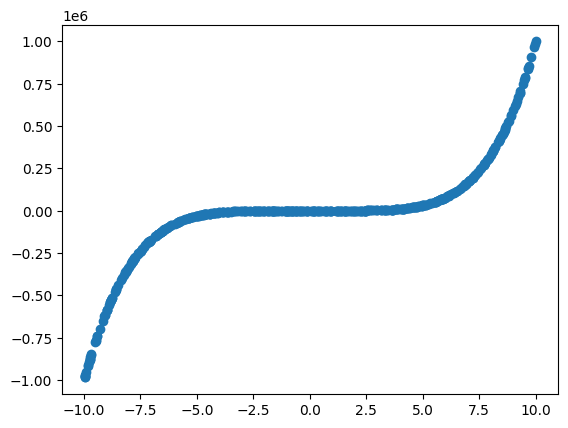

In [ ]:
plt.scatter(test_X, test_y)

In [ ]:
normalizer = tf.keras.layers.Normalization(input_shape=(1,))
normalizer.adapt(np.array(test_X).reshape(-1,1))

In [ ]:
normalizer.mean.numpy()

array([[-1.3079627]], dtype=float32)

In [ ]:
test_X

array([ 36.46531581,  61.14046761,  34.28550923, ...,  33.29975966,
       -96.51224811,  -7.38235016])

In [ ]:
# inputs = tf.keras.Input(shape=(1,))
# normzalize = normalizer(inputs)
# outputs = tf.keras.layers.Dense(1,activation='sigmoid')(normzalize)
# test = tf.keras.Model(inputs=inputs, outputs=outputs)

# test_model = tf.keras.Sequential([
#     # normalizer,
#     tf.keras.layers.Input(shape=(1,)),
#     tf.keras.layers.Dense(units=64, activation='relu'),
#     # tf.keras.layers.Dense(units=64, activation='relu'),
#     tf.keras.layers.Dense(units=32, activation='relu'),
#     tf.keras.layers.Dense(units=16, activation='relu'),
#     tf.keras.layers.Dense(units=1),
# ])
# test_model.compile(optimizer='adam', loss='mean_squared_error')

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')
test_X, test_y = np.expand_dims(test_X,axis=1), np.expand_dims(test_y, axis=1)
history = model.fit(test_X, test_y, epochs = 100, validation_split = 0.1, verbose = 2)

Epoch [100/1000], Loss: nan
Epoch [200/1000], Loss: nan
Epoch [300/1000], Loss: nan
Epoch [400/1000], Loss: nan
Epoch [500/1000], Loss: nan
Epoch [600/1000], Loss: nan
Epoch [700/1000], Loss: nan
Epoch [800/1000], Loss: nan
Epoch [900/1000], Loss: nan
Epoch [1000/1000], Loss: nan


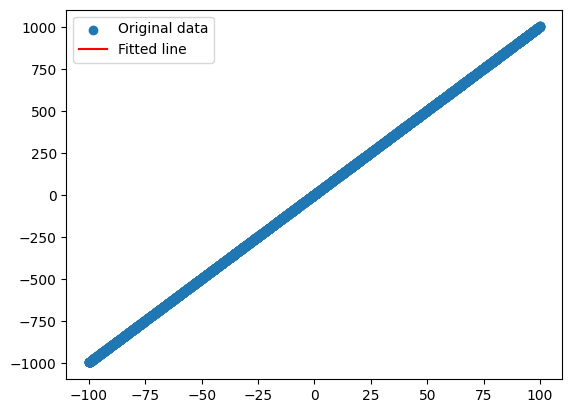

In [ ]:

# Generate some random data
np.random.seed(0)
x = np.random.rand(100, 1) * 10
y = 2 * x + 1 + np.random.randn(100, 1)

# Convert data to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Define the neural network model
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(1, 10)  # Input layer: 1 input feature, 10 neurons in the hidden layer
        self.fc2 = nn.Linear(10, 1)  # Output layer: 1 output feature

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = RegressionNN()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(x_tensor)
    loss = criterion(outputs, y_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot the original data and the predicted values
with torch.no_grad():
    predicted = model(x_tensor).detach().numpy()

plt.scatter(x, y, label='Original data')
plt.plot(x, predicted, 'r', label='Fitted line')
plt.legend()
plt.show()


In [ ]:
np.expand_dims(test_X,1).shape, y.shape, test_y.shape, np.expand_dims(test_y,axis=1).shape

((5000, 1), (100, 1), (5000,), (5000, 1))

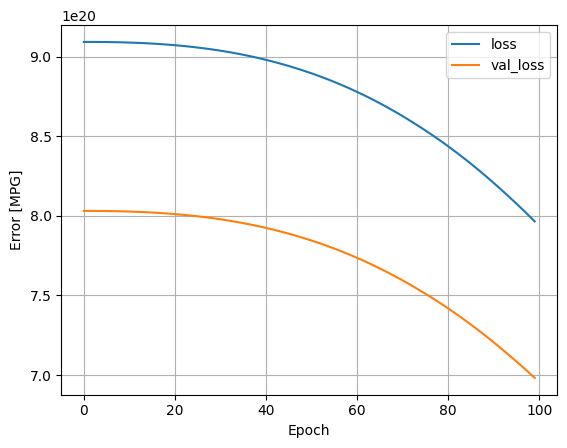

In [ ]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


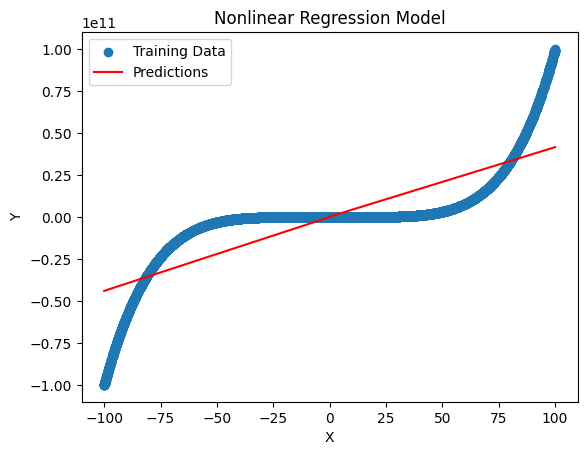

In [ ]:
# Generate test data
X_test = np.linspace(-100, 100, 100).reshape(-1, 1)

# Predictions
Y_pred = test_model.predict(X_test)

# Plot results
plt.scatter(test_X, test_y, label='Training Data')
plt.plot(X_test, Y_pred, color='red', label='Predictions')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Nonlinear Regression Model')
plt.legend()
plt.show()


In [ ]:
# Generate dataset
np.random.seed(0)
X_train = np.random.uniform(-5, 5, 1000).reshape(-1, 1)
Y_train = X_train ** 2 + 3 + np.random.normal(0, 1, X_train.shape)

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X_train, Y_train, epochs=100, verbose=2)


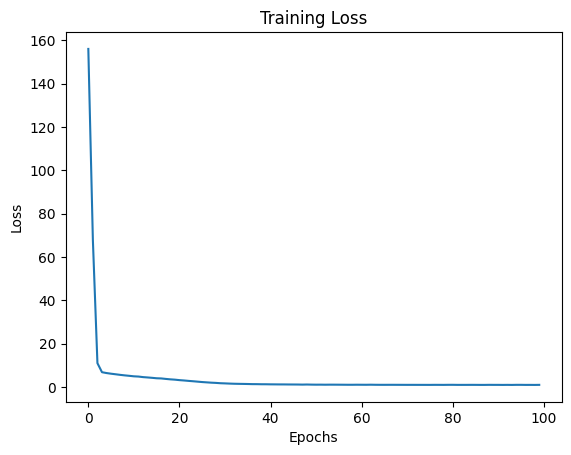

In [ ]:
# Plot training loss
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

4/4 [==============================] - 0s 3ms/step


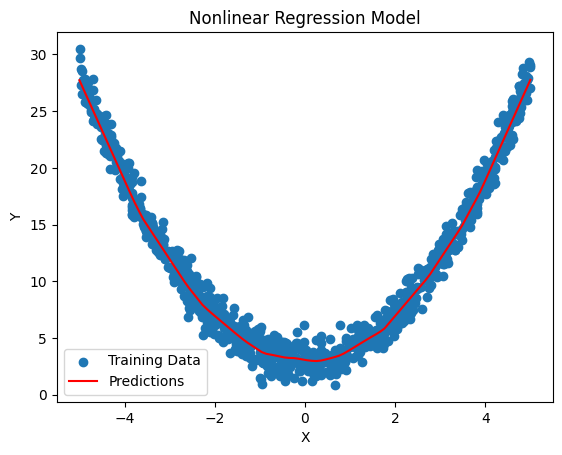

In [ ]:
# Generate test data
X_test = np.linspace(-5, 5, 100).reshape(-1, 1)

# Predictions
Y_pred = model.predict(X_test)

# Plot results
plt.scatter(X_train, Y_train, label='Training Data')
plt.plot(X_test, Y_pred, color='red', label='Predictions')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Nonlinear Regression Model')
plt.legend()
plt.show()


### Random seed to generate n states
sequence of states generated should be same

In [2]:
import numpy as np

In [21]:
np.random.seed(1)
n = 1

C = 5
t1_upper_bound = 100
t2_upper_bound = 100
np.random.randint([0,0,0,0],[C+1,C+1, t1_upper_bound, t2_upper_bound], (n,4))

array([[ 5,  3, 12, 72]])

In [23]:
state = sample_random_state(1)

In [24]:
state

array([[ 1,  3,  5, 79]])

In [27]:
n1,n2,t1,t2 = state.flatten()

In [28]:
n1,n2,t1,t2

(1, 3, 5, 79)

In [30]:
state.flatten(), state.ravel()

(array([ 1,  3,  5, 79]), array([ 1,  3,  5, 79]))

In [34]:
np.array((n1,n2,t1,t2),ndmin=2)

array([[ 1,  3,  5, 79]])